# Statistical Two Sample t-test Across Noise

July 31, 2022

In [1]:
folder = 'figs-2022-8-1/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d
import scipy

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


# Upload RL Data from Figure 2, and do Two-way t-test

In [4]:
""" load data from 2022-5-5 """

file = '../NeurIPS-2022-4-29/figures-2022-5-05/stats_reinforce_wout.pickle'
with open(file, 'rb') as fp:
    stats_reinforce_wout = pickle.load(fp)

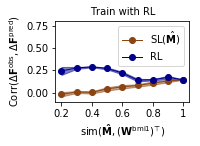

In [7]:
""" Same plot using flow field """

save = False
paper = True

overlaps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

fig,ax = plt.subplots(1,1)
lw = 1
fs = 18




n_samples = len(stats_reinforce_wout['corr1'])
mn1 = np.mean(np.asarray(stats_reinforce_wout['corr1']),axis=0)
std1 = np.std(np.asarray(stats_reinforce_wout['corr1']),axis=0)
sem1 = std1/np.sqrt(n_samples)

mn2 = np.mean(np.asarray(stats_reinforce_wout['corr2']),axis=0)
std2 = np.std(np.asarray(stats_reinforce_wout['corr2']),axis=0)
sem2 = std2/np.sqrt(n_samples)

# mn3 = np.mean(np.asarray(stats_reinforce_wout['corr3']),axis=0)
# std3 = np.std(np.asarray(stats_reinforce_wout['corr3']),axis=0)
# sem3 = std3/np.sqrt(n_samples)

plt.plot(overlaps[:],mn1,'o-',linewidth=lw,label='SL('+r'$\hat{\mathbf{M}})$',color='saddlebrown')
plt.fill_between(overlaps[:],mn1-sem1,mn1+sem1,alpha=0.5,color='saddlebrown')

plt.plot(overlaps[:],mn2,'o-',linewidth=lw,label='RL',color='darkblue')
plt.fill_between(overlaps[:],mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')

# plt.plot(overlaps[:],mn3,'o-',linewidth=lw,label='M=0.5',color='tomato')
# plt.fill_between(overlaps[:],mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')

plt.legend(fontsize=fs)
plt.title('Train with RL',fontsize=fs)
plt.xlabel('sim('+r'$\mathbf{\hat{M}},(\mathbf{W}^{\mathrm{bmi}1})^\top)$',fontsize=fs)
plt.ylabel('Corr'+r'$(\Delta \mathbf{F}^{\mathrm{obs}}, \Delta \mathbf{F}^{\mathrm{pred}})$')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

if paper:
    
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.2,0.4,0.6,0.8,1],ticksize=10,linewidth=2,ylim=[-0.1,0.8],figsize=(2.25,3))

    
else:
    plt.ylim([-0.2,0.8])


plt.tight_layout()
plt.show()


if save:
    if paper:
        fig.savefig(folder+'fig2b-reinforce-dF-change-alignment.pdf')
    else:
        fig.savefig(folder+'fig2b-reinforce-dF-change-alignment_large.pdf')

0.20 p-value: 0.004497114625779787
0.30 p-value: 5.95490747017804e-06
0.40 p-value: 2.6918061938438868e-06
0.50 p-value: 8.914793823730036e-05
0.60 p-value: 0.001586105929497841
0.70 p-value: 0.04443828602532752
0.80 p-value: 0.1684134268556855
0.90 p-value: 0.15071849349652014
1.00 p-value: 1.0


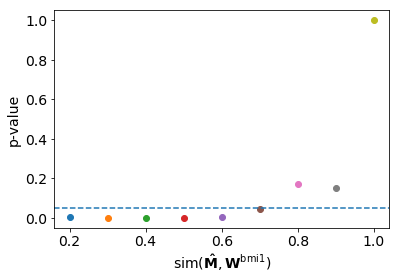

In [9]:
import scipy

overlaps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for i in range(9):
    x = np.asarray(stats_reinforce_wout['corr1'])[:,i]
    y = np.asarray(stats_reinforce_wout['corr2'])[:,i]

    ttest = scipy.stats.ttest_ind(x,y)

    plt.plot(overlaps[i],ttest.pvalue,'o')
    print('{:.2f} p-value: {}'.format(overlaps[i],ttest.pvalue))
    
plt.axhline(0.05,linestyle='--')
plt.xlabel('sim('+r'$\mathbf{\hat{M}},\mathbf{W}^{\mathrm{bmi}1})$')
plt.ylabel('p-value')
plt.show()

# SL Case with varying noise

# RFLO with varied M

In [5]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

standard sig_rec is sig_rec=0.25


I can do the same experiment with sig_rec = 0.5 and sig_rec = 0.1

Save each one and 

Orginal parameters

seeds = [0,22,33,47]
overlaps = [0.4,0.5,0.6,0.7,0.8,0.9,1]
n_changes = [60,50,50,50,30,30,0]
overlap_w_out0 = 0.5
n_change_w_out0 = 50

3it [00:00, 28.31it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.5
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fda13901480>


2500it [00:27, 90.09it/s]
9it [00:00, 88.49it/s]

M norm: 1.32	 M angle: 0.41, 113 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.32	 w_out1 vs. w_m angle: 0.41
w_m norm: 1.84	 w_out vs. w_m angle: 0.15

500it [00:04, 113.04it/s]
1500it [00:17, 85.12it/s]
500it [00:04, 103.46it/s]


AR early fit 0.902, late fit 0.933


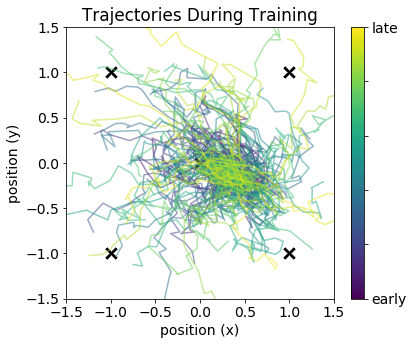

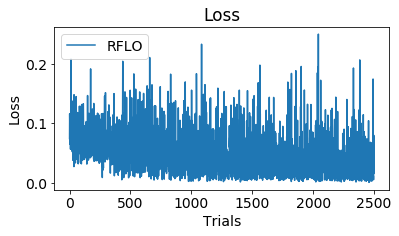

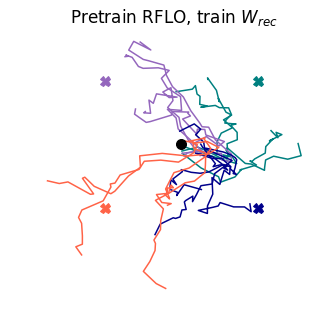

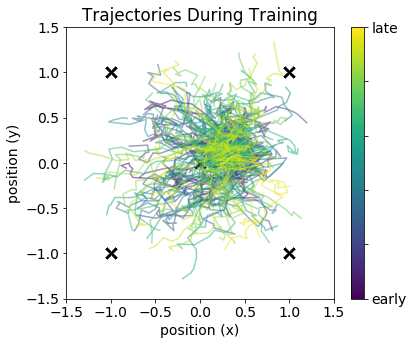

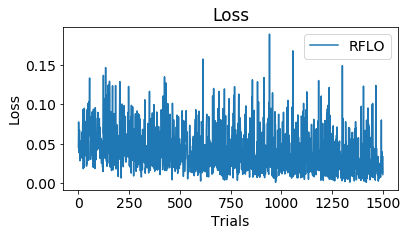

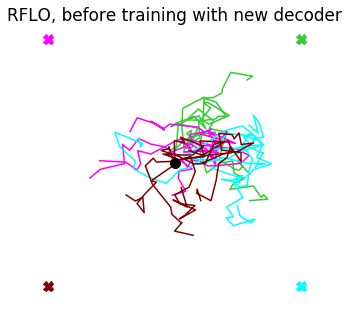

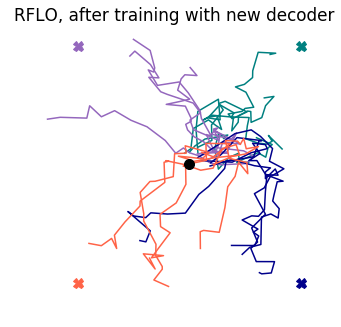

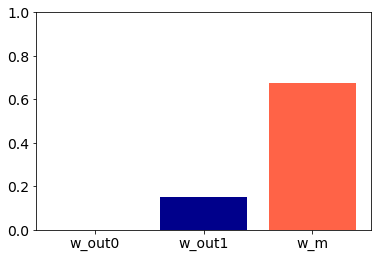

9it [00:00, 89.08it/s]

M norm: 1.21	 M angle: 0.49, 34 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.21	 w_out1 vs. w_m angle: 0.49
w_m norm: 1.85	 w_out vs. w_m angle: 0.11

500it [00:04, 106.70it/s]
1500it [00:17, 85.74it/s]
500it [00:04, 109.88it/s]


AR early fit 0.902, late fit 0.915


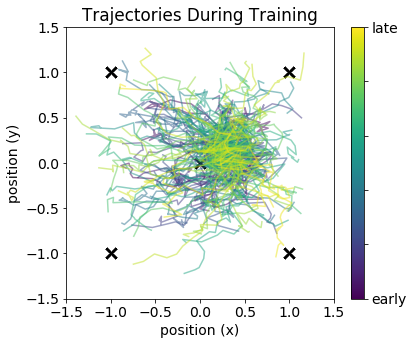

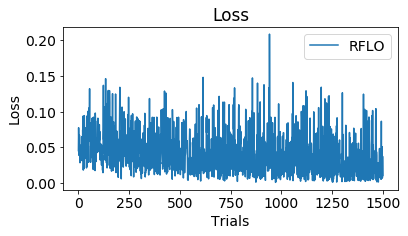

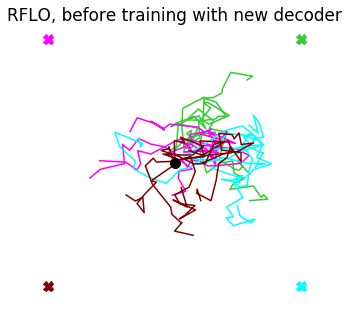

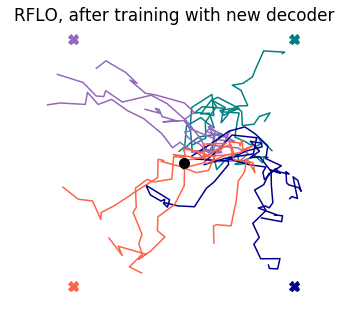

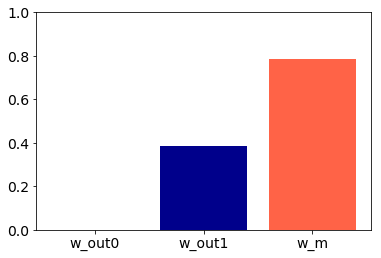

7it [00:00, 67.37it/s]

M norm: 1.11	 M angle: 0.60, 12 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.72	 w_out vs. w_m angle: 0.29

500it [00:04, 108.32it/s]
1500it [00:18, 81.38it/s]
500it [00:05, 97.88it/s]


AR early fit 0.902, late fit 0.929


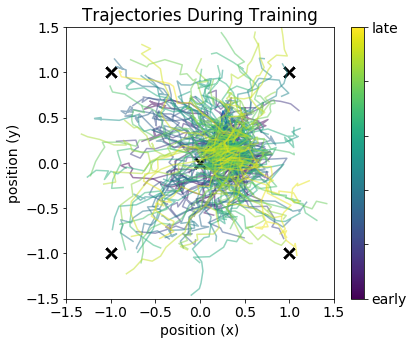

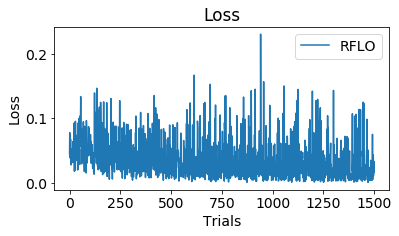

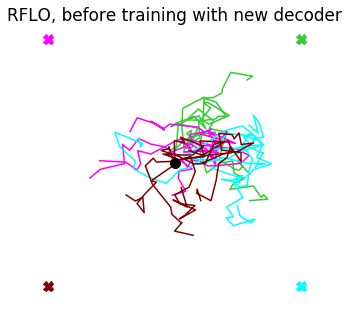

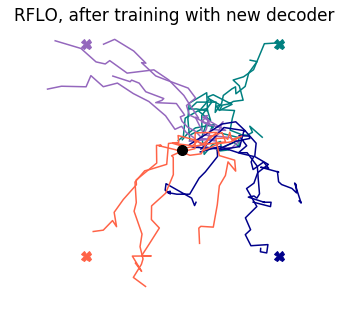

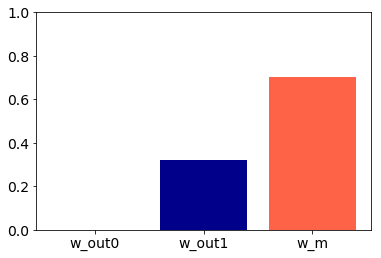

8it [00:00, 79.09it/s]

M norm: 0.97	 M angle: 0.70, 4 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.97	 w_out1 vs. w_m angle: 0.70
w_m norm: 1.67	 w_out vs. w_m angle: 0.33

500it [00:04, 111.11it/s]
1500it [00:17, 85.12it/s]
500it [00:05, 96.70it/s] 


AR early fit 0.902, late fit 0.927


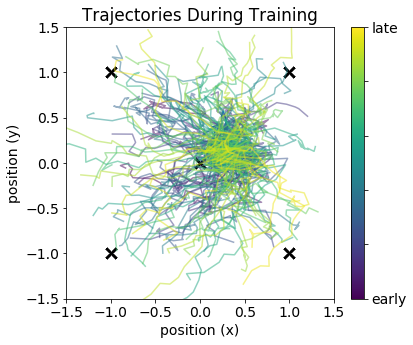

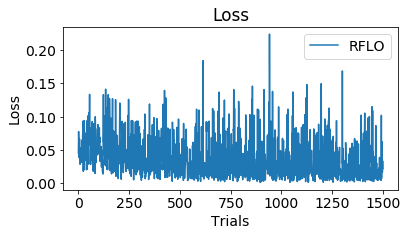

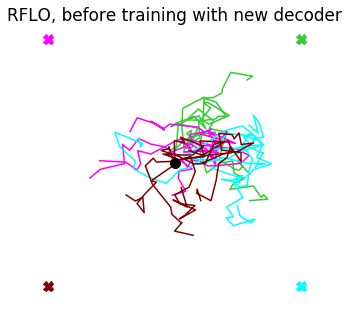

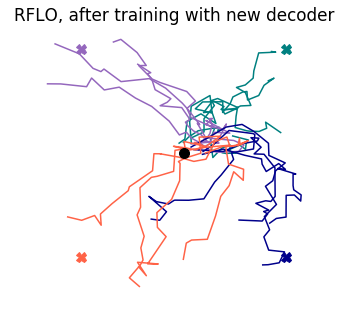

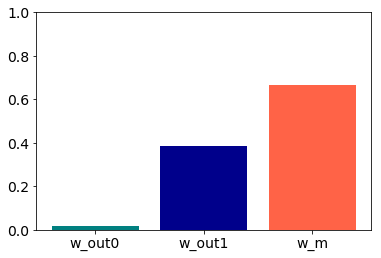

7it [00:00, 67.27it/s]

M norm: 0.80	 M angle: 0.81, 2 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.80	 w_out1 vs. w_m angle: 0.81
w_m norm: 1.69	 w_out vs. w_m angle: 0.35

500it [00:04, 107.59it/s]
1500it [00:18, 79.86it/s]
500it [00:04, 113.28it/s]


AR early fit 0.902, late fit 0.920


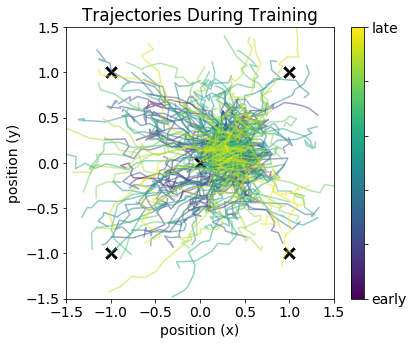

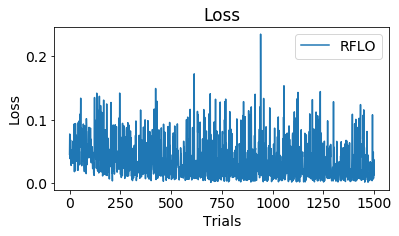

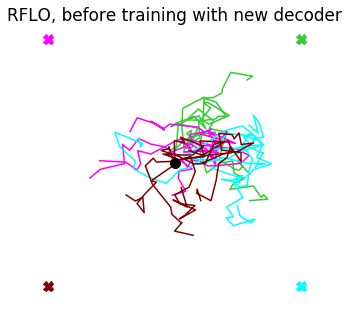

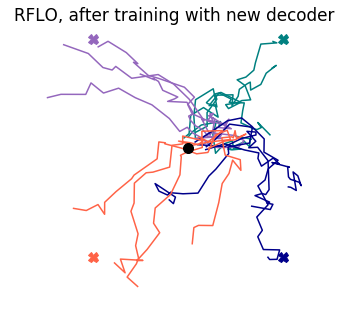

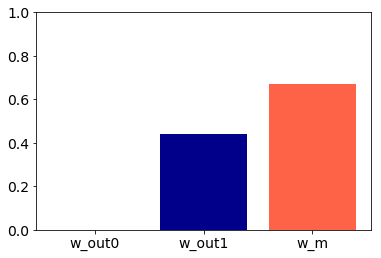

10it [00:00, 93.50it/s]

M norm: 0.56	 M angle: 0.91, 29 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.56	 w_out1 vs. w_m angle: 0.91
w_m norm: 1.63	 w_out vs. w_m angle: 0.40

500it [00:03, 129.08it/s]
1500it [00:17, 86.38it/s]
500it [00:04, 104.42it/s]


AR early fit 0.902, late fit 0.924


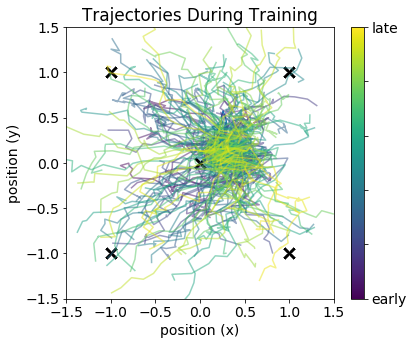

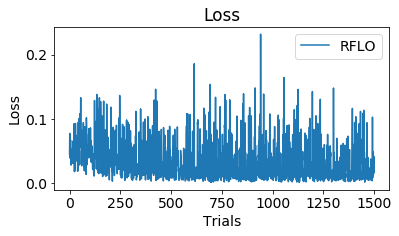

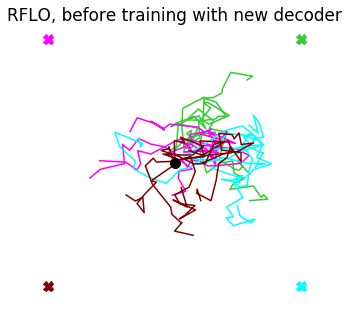

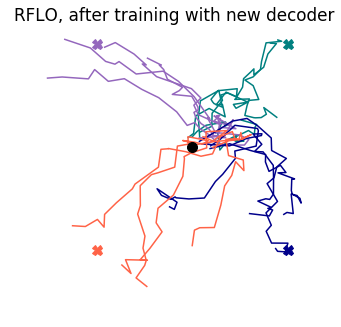

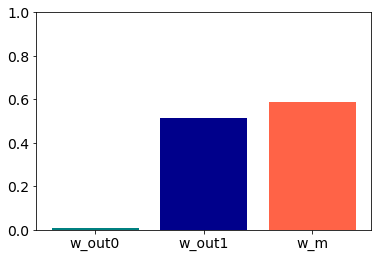

11it [00:00, 105.64it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations
w_out1 norm: 1.52	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.00	 w_out1 vs. w_m angle: 1.00
w_m norm: 1.52	 w_out vs. w_m angle: 0.51

500it [00:04, 109.20it/s]
1500it [00:15, 96.98it/s]
500it [00:04, 113.12it/s]


AR early fit 0.902, late fit 0.923


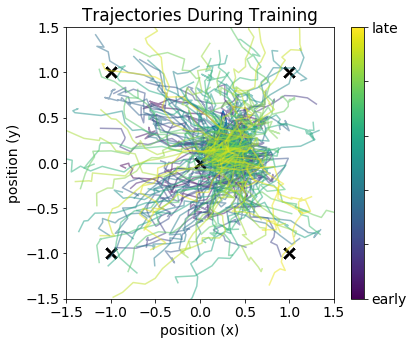

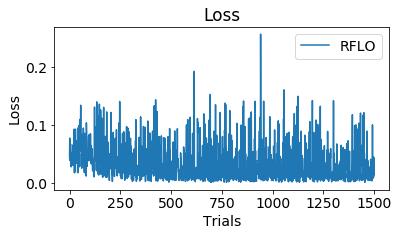

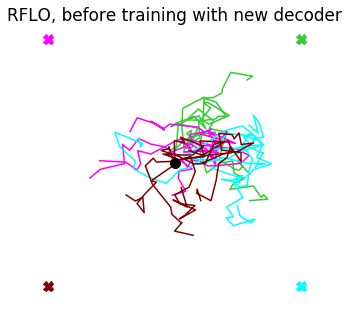

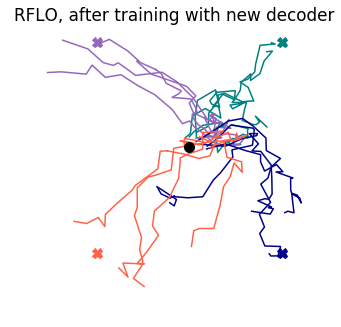

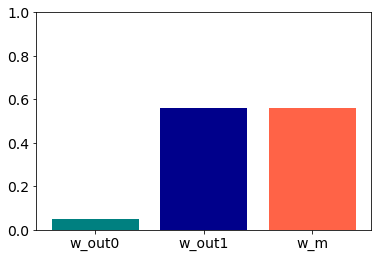

8it [00:00, 72.28it/s]

M norm: 1.18	 M angle: 0.39, 47 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.18	 w_out1 vs. w_m angle: 0.39
w_m norm: 1.78	 w_out vs. w_m angle: 0.12

500it [00:04, 112.89it/s]
1500it [00:20, 74.13it/s]
500it [00:03, 127.58it/s]


AR early fit 0.902, late fit 0.931


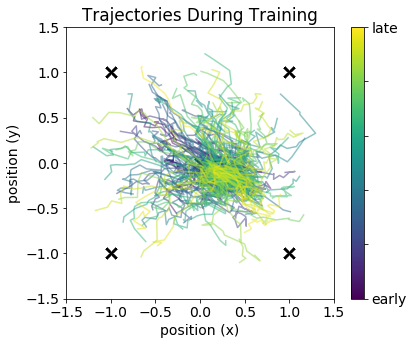

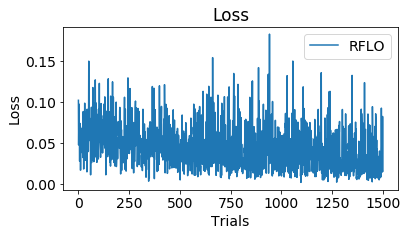

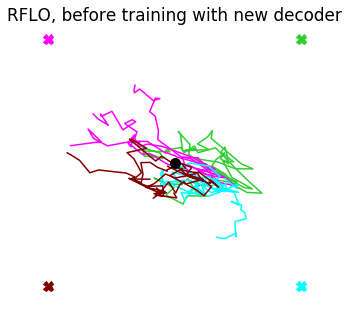

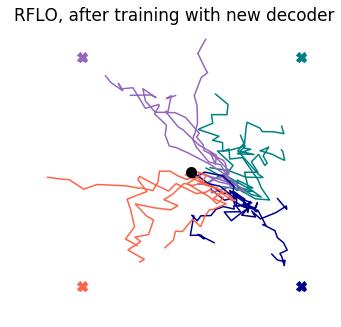

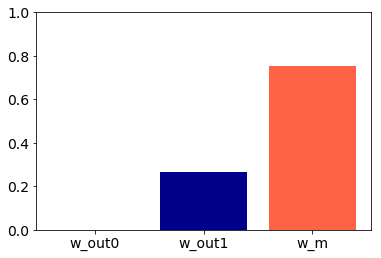

5it [00:00, 46.57it/s]

M norm: 1.13	 M angle: 0.50, 5 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.13	 w_out1 vs. w_m angle: 0.50
w_m norm: 1.76	 w_out vs. w_m angle: 0.21

500it [00:05, 99.67it/s] 
1500it [00:15, 99.75it/s]
500it [00:03, 129.15it/s]


AR early fit 0.902, late fit 0.924


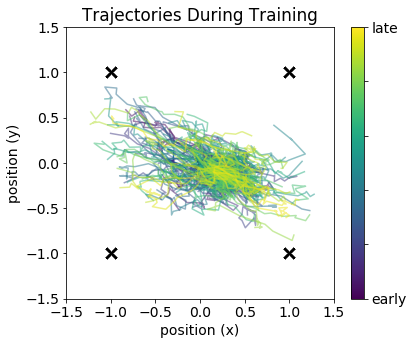

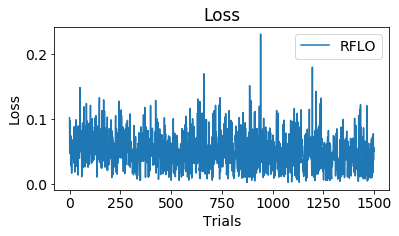

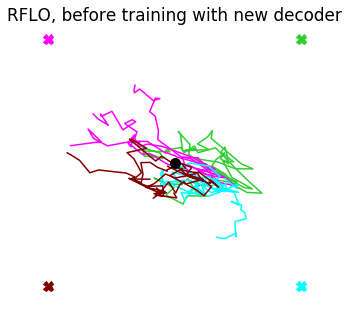

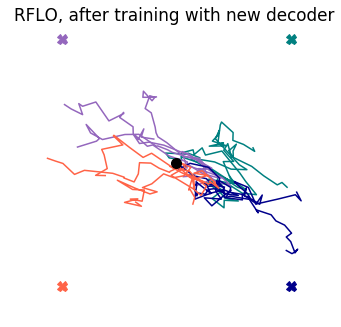

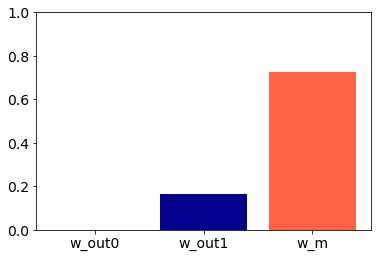

7it [00:00, 69.87it/s]

M norm: 1.01	 M angle: 0.61, 14 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.01	 w_out1 vs. w_m angle: 0.61
w_m norm: 1.67	 w_out vs. w_m angle: 0.31

500it [00:03, 126.91it/s]
1500it [00:16, 90.43it/s]
500it [00:05, 97.91it/s]


AR early fit 0.902, late fit 0.931


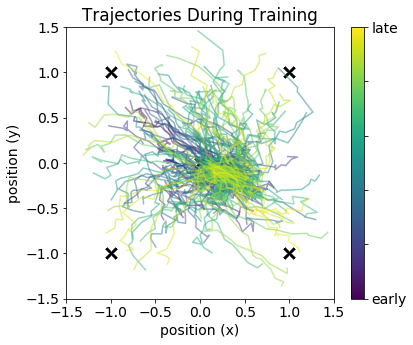

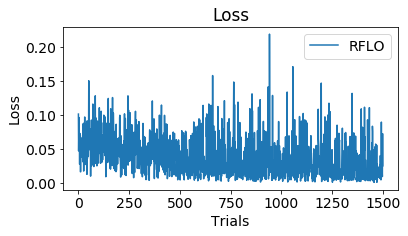

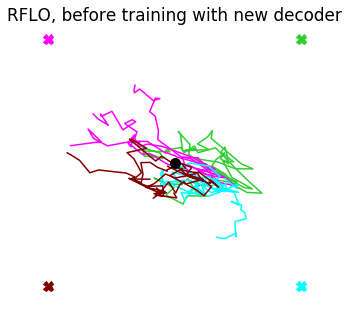

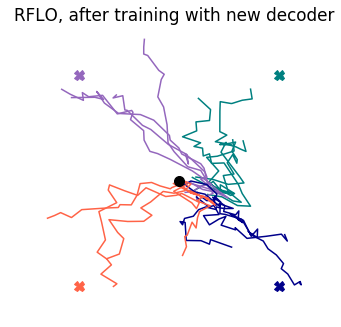

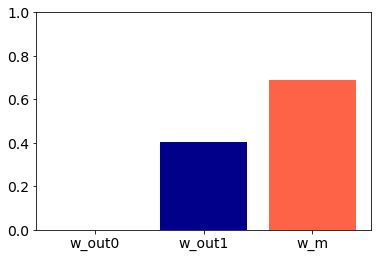

7it [00:00, 67.77it/s]

M norm: 0.89	 M angle: 0.70, 17 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.89	 w_out1 vs. w_m angle: 0.70
w_m norm: 1.57	 w_out vs. w_m angle: 0.41

500it [00:04, 118.62it/s]
1500it [00:15, 98.61it/s]
500it [00:03, 128.13it/s]


AR early fit 0.902, late fit 0.933


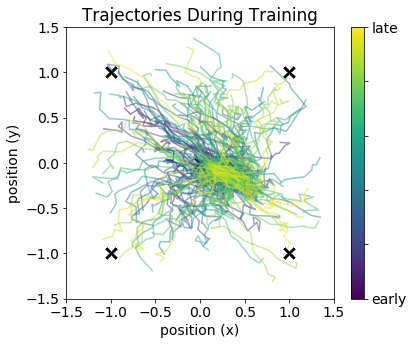

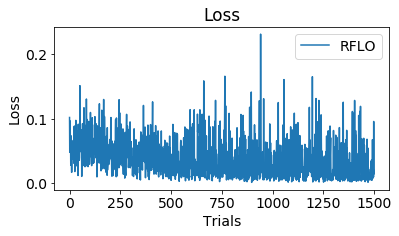

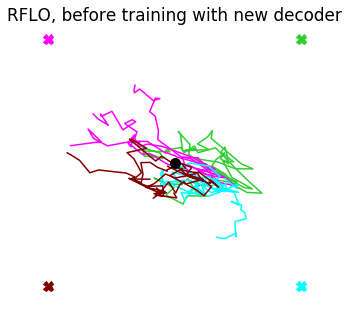

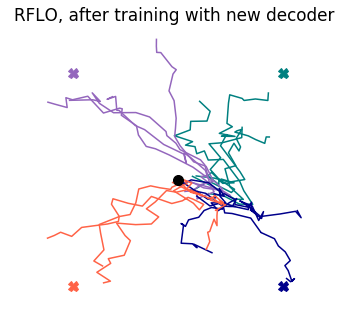

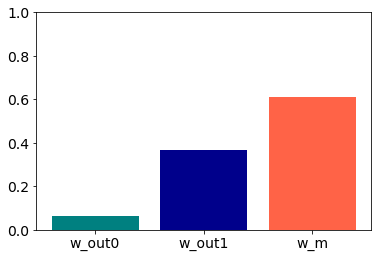

8it [00:00, 77.73it/s]

M norm: 0.73	 M angle: 0.80, 0 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.73	 w_out1 vs. w_m angle: 0.80
w_m norm: 1.66	 w_out vs. w_m angle: 0.33

500it [00:04, 124.69it/s]
1500it [00:18, 73.96it/s]
500it [00:04, 108.83it/s]


AR early fit 0.902, late fit 0.928


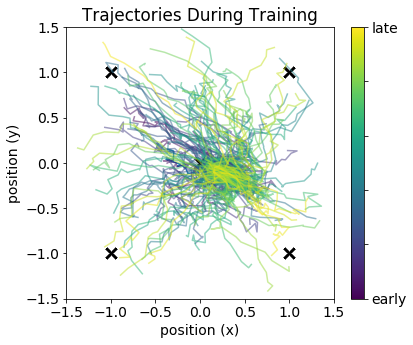

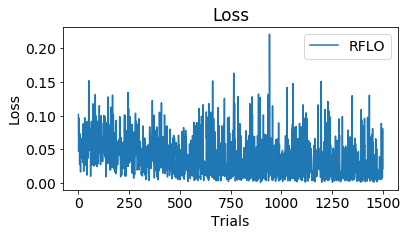

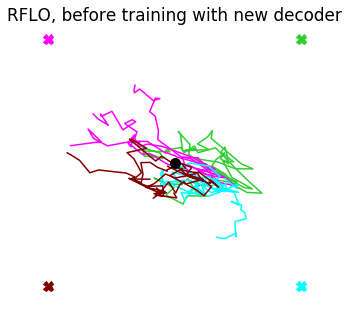

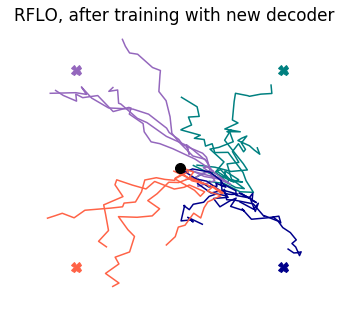

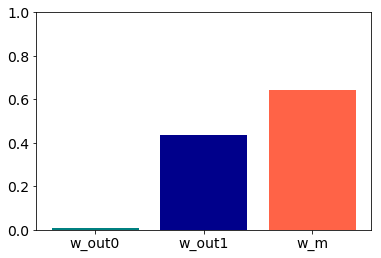

6it [00:00, 53.70it/s]

M norm: 0.53	 M angle: 0.90, 252 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.53	 w_out1 vs. w_m angle: 0.90
w_m norm: 1.55	 w_out vs. w_m angle: 0.45

500it [00:05, 89.50it/s]
1500it [00:19, 78.93it/s]
500it [00:05, 98.15it/s] 


AR early fit 0.902, late fit 0.933


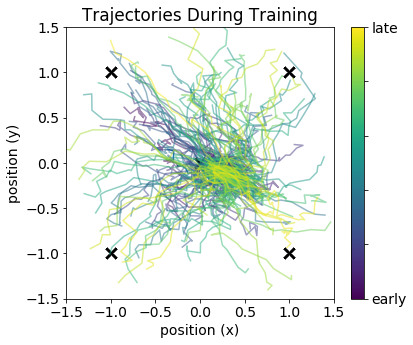

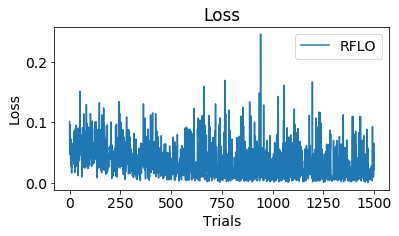

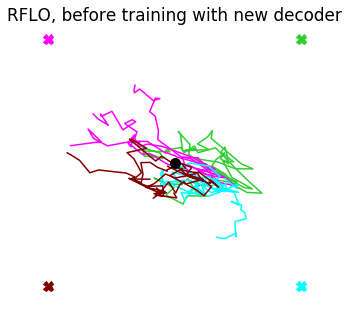

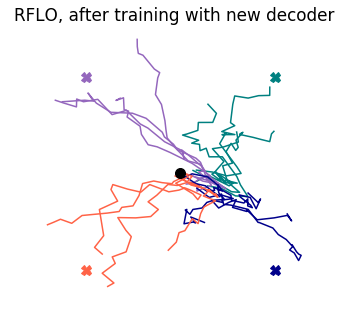

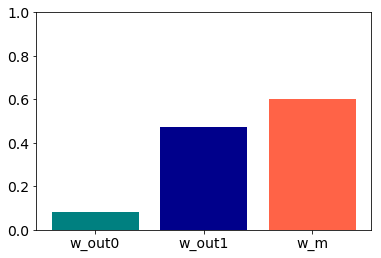

3it [00:00, 20.71it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.00	 w_out1 vs. w_m angle: 1.00
w_m norm: 1.50	 w_out vs. w_m angle: 0.50

500it [00:04, 112.20it/s]
1500it [00:16, 64.74it/s]
500it [00:04, 124.43it/s]


AR early fit 0.902, late fit 0.927


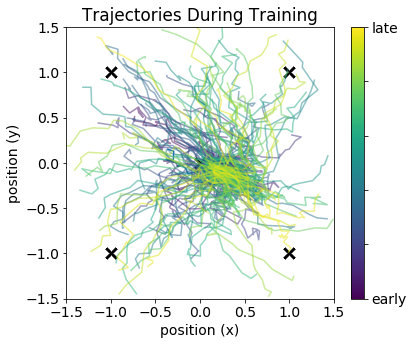

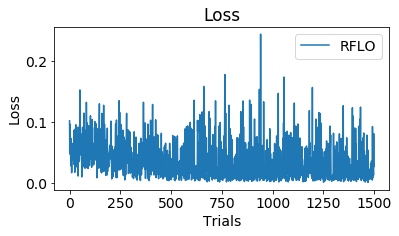

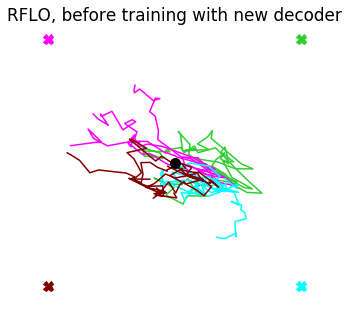

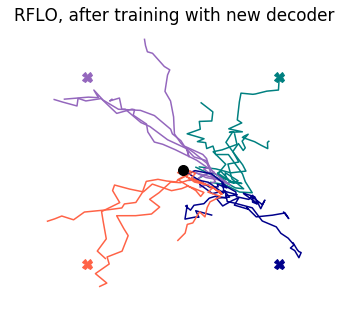

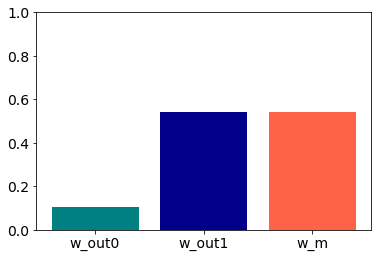

12it [00:00, 118.56it/s]

M norm: 1.28	 M angle: 0.40, 7 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.28	 w_out1 vs. w_m angle: 0.40
w_m norm: 1.77	 w_out vs. w_m angle: 0.23

500it [00:04, 118.31it/s]
1500it [00:17, 87.35it/s]
500it [00:04, 110.80it/s]


AR early fit 0.902, late fit 0.931


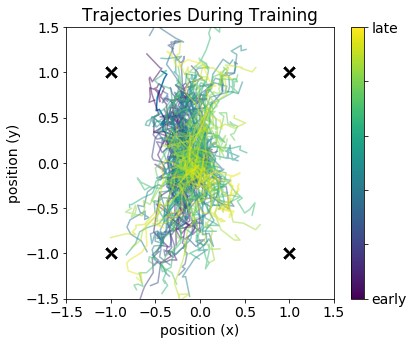

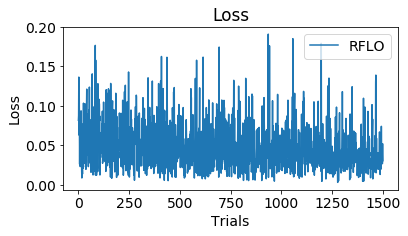

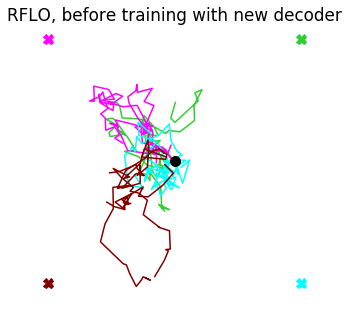

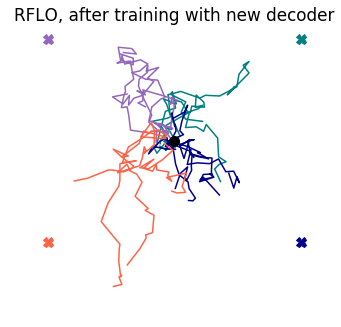

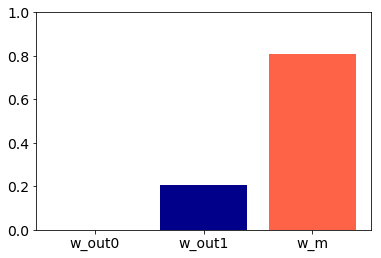

9it [00:00, 88.17it/s]

M norm: 1.14	 M angle: 0.51, 9 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.14	 w_out1 vs. w_m angle: 0.51
w_m norm: 1.84	 w_out vs. w_m angle: 0.14

500it [00:04, 110.86it/s]
1500it [00:17, 86.62it/s]
500it [00:04, 118.56it/s]


AR early fit 0.902, late fit 0.922


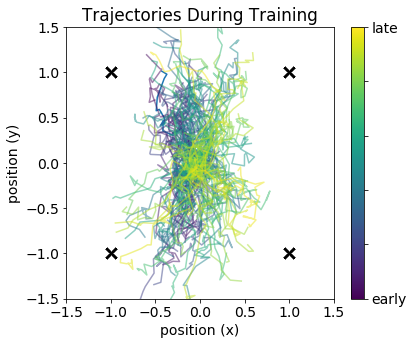

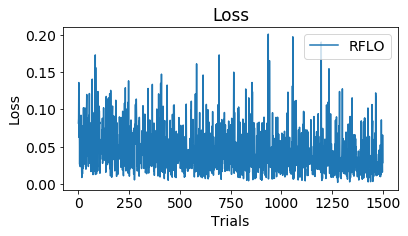

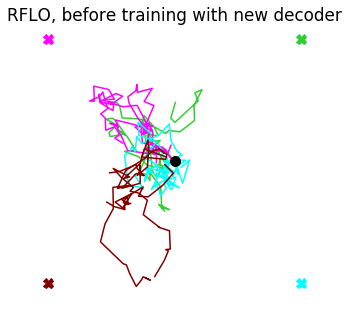

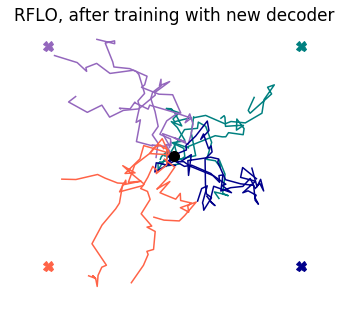

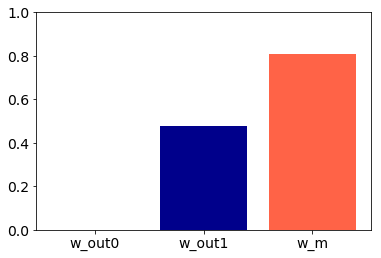

11it [00:00, 109.66it/s]

M norm: 1.07	 M angle: 0.59, 17 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 1.07	 w_out1 vs. w_m angle: 0.59
w_m norm: 1.64	 w_out vs. w_m angle: 0.36

500it [00:04, 120.64it/s]
1500it [00:15, 95.50it/s]
500it [00:04, 110.76it/s]


AR early fit 0.902, late fit 0.921


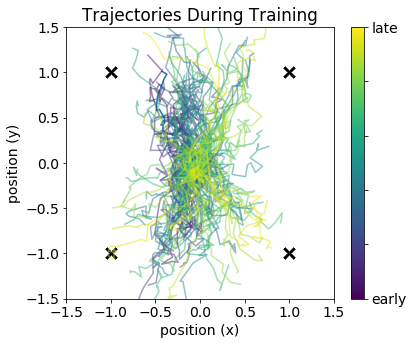

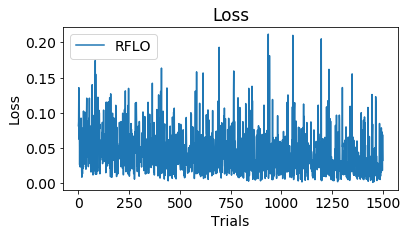

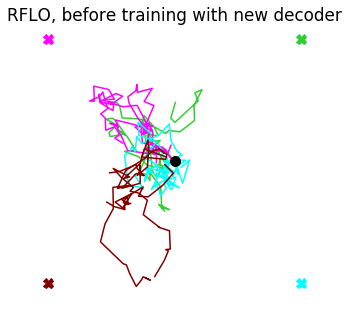

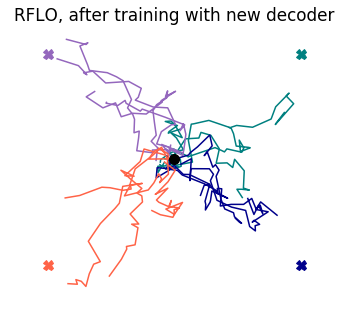

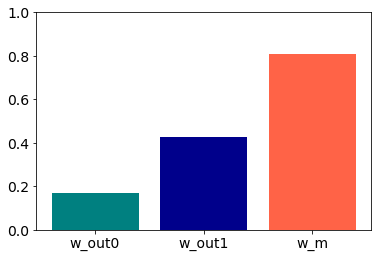

11it [00:00, 100.84it/s]

M norm: 0.93	 M angle: 0.70, 0 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.93	 w_out1 vs. w_m angle: 0.70
w_m norm: 1.45	 w_out vs. w_m angle: 0.52

500it [00:04, 123.05it/s]
1500it [00:15, 94.36it/s]
500it [00:03, 128.63it/s]


AR early fit 0.902, late fit 0.925


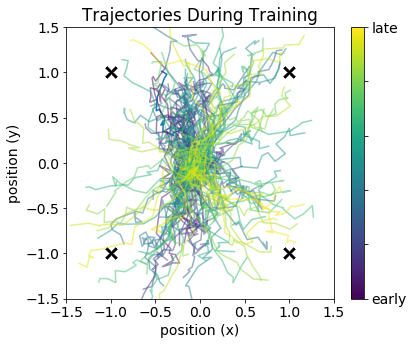

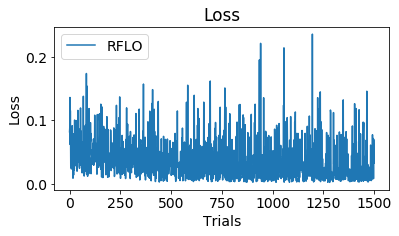

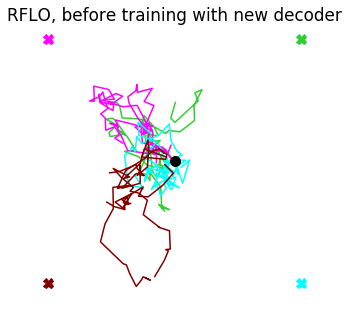

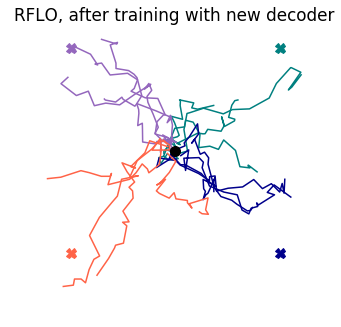

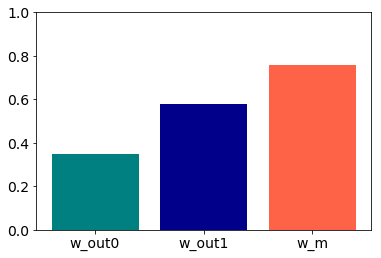

12it [00:00, 117.80it/s]

M norm: 0.76	 M angle: 0.80, 10 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.76	 w_out1 vs. w_m angle: 0.80
w_m norm: 1.56	 w_out vs. w_m angle: 0.43

500it [00:03, 125.51it/s]
1500it [00:15, 94.10it/s] 
500it [00:03, 131.01it/s]


AR early fit 0.902, late fit 0.919


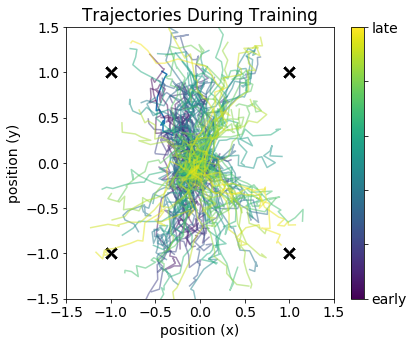

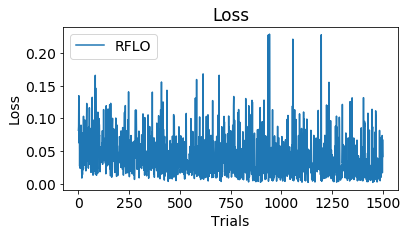

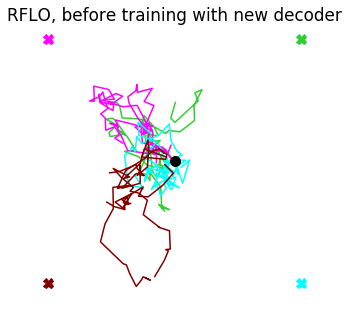

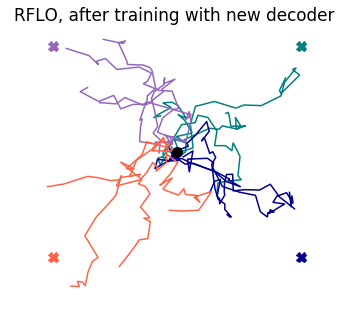

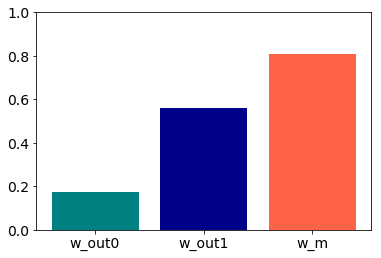

13it [00:00, 121.75it/s]

M norm: 0.54	 M angle: 0.90, 1 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.54	 w_out1 vs. w_m angle: 0.90
w_m norm: 1.50	 w_out vs. w_m angle: 0.50

500it [00:03, 129.65it/s]
1500it [00:14, 100.26it/s]
500it [00:03, 128.85it/s]


AR early fit 0.902, late fit 0.919


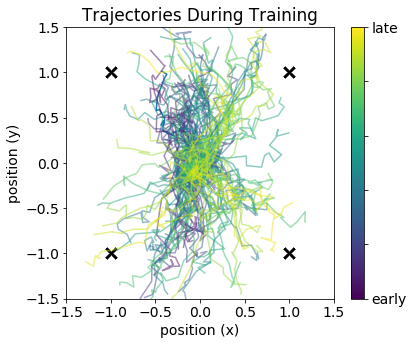

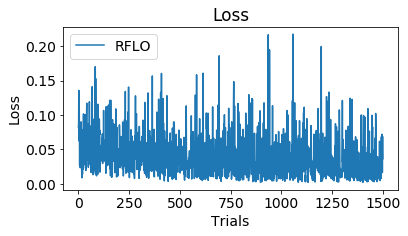

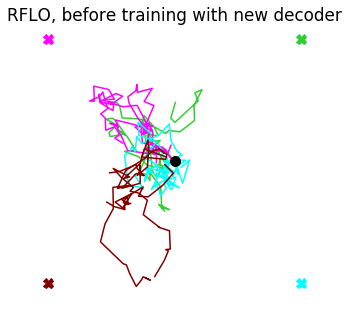

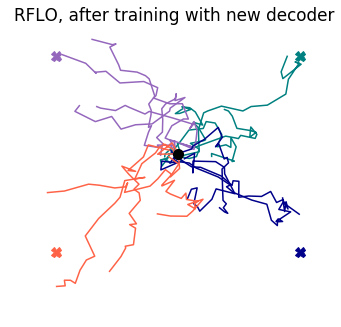

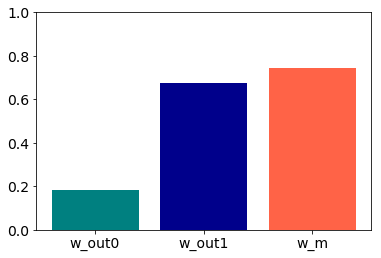

13it [00:00, 119.00it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations
w_out1 norm: 1.50	 w_out vs. w_out1 angle: 0.50
w_m norm: 0.00	 w_out1 vs. w_m angle: 1.00
w_m norm: 1.50	 w_out vs. w_m angle: 0.50

500it [00:03, 129.37it/s]
1500it [00:15, 96.06it/s]
500it [00:03, 127.64it/s]


AR early fit 0.902, late fit 0.920


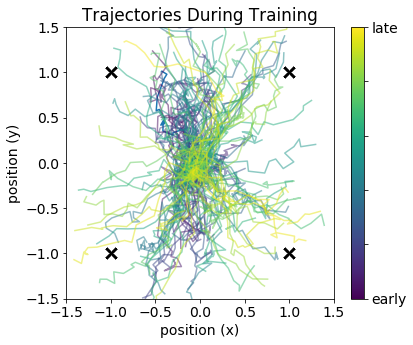

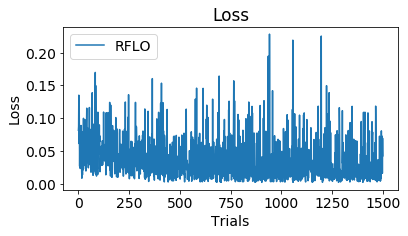

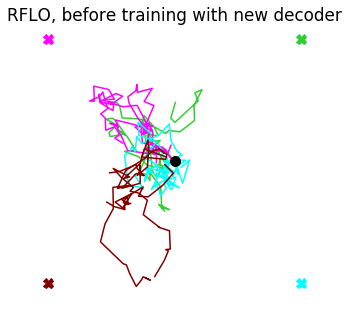

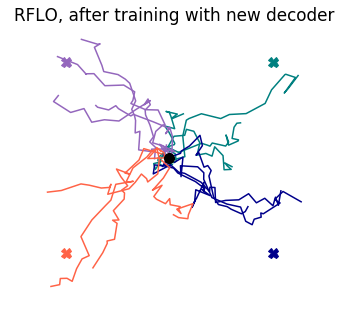

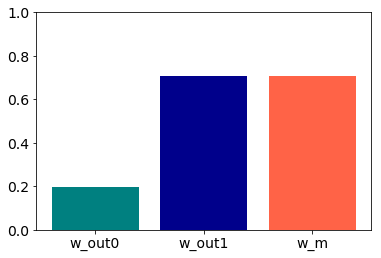

13it [00:00, 124.97it/s]

M norm: 1.17	 M angle: 0.39, 6 iterations
w_out1 norm: 1.47	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.17	 w_out1 vs. w_m angle: 0.39
w_m norm: 1.76	 w_out vs. w_m angle: 0.16

500it [00:03, 128.91it/s]
1500it [00:14, 100.71it/s]
500it [00:03, 128.93it/s]


AR early fit 0.902, late fit 0.921


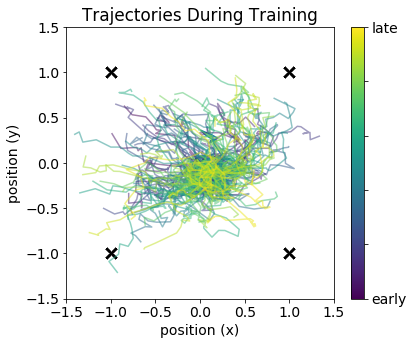

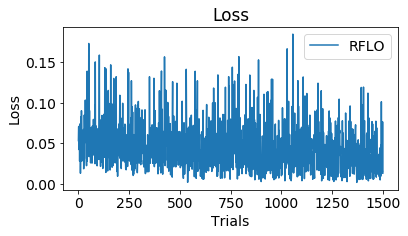

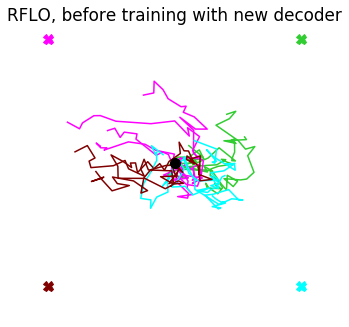

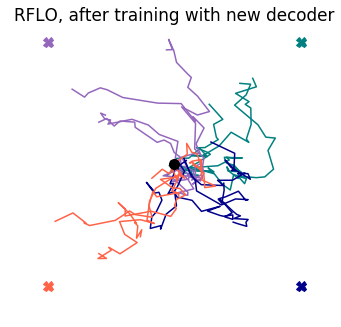

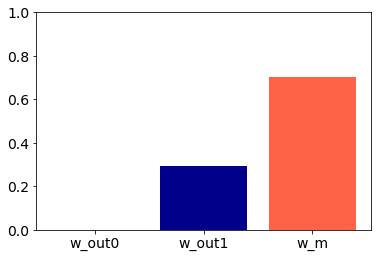

12it [00:00, 117.69it/s]

M norm: 1.11	 M angle: 0.50, 11 iterations
w_out1 norm: 1.47	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.11	 w_out1 vs. w_m angle: 0.50
w_m norm: 1.70	 w_out vs. w_m angle: 0.26

500it [00:04, 120.64it/s]
1500it [00:15, 97.70it/s] 
500it [00:04, 123.33it/s]


AR early fit 0.902, late fit 0.930


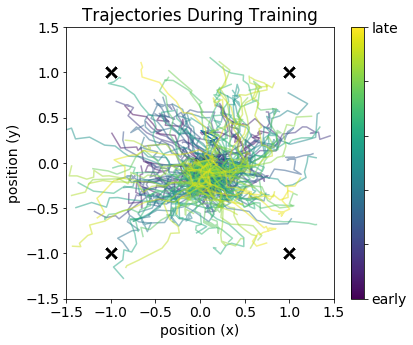

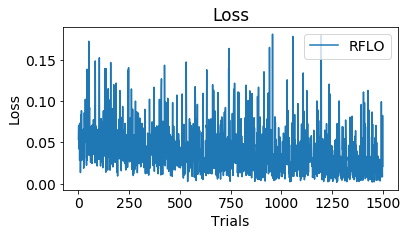

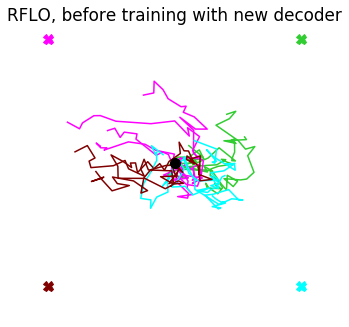

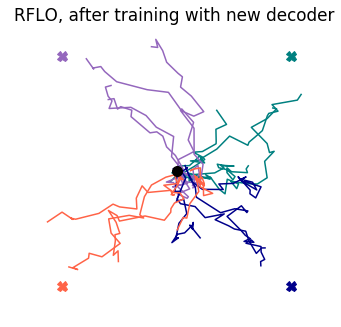

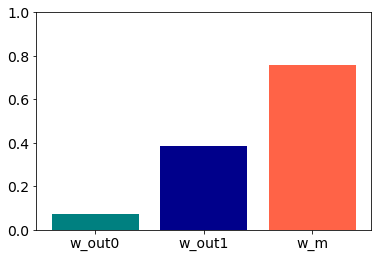

11it [00:00, 105.92it/s]

M norm: 1.00	 M angle: 0.60, 3 iterations
w_out1 norm: 1.47	 w_out vs. w_out1 angle: 0.51
w_m norm: 1.00	 w_out1 vs. w_m angle: 0.60
w_m norm: 1.56	 w_out vs. w_m angle: 0.41

500it [00:03, 128.87it/s]
1500it [00:14, 100.23it/s]
500it [00:03, 128.33it/s]


AR early fit 0.902, late fit 0.932


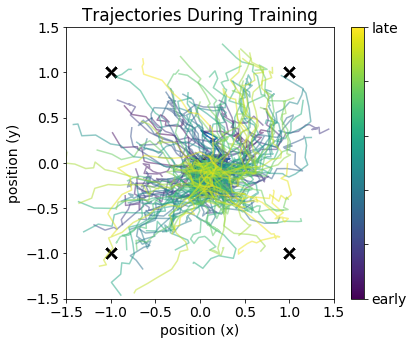

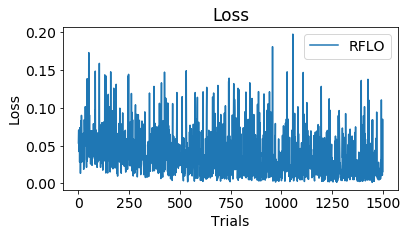

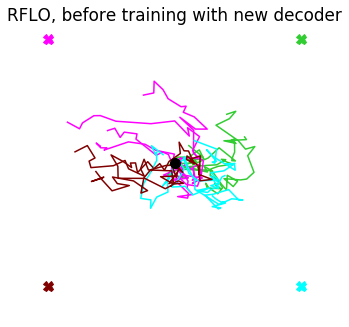

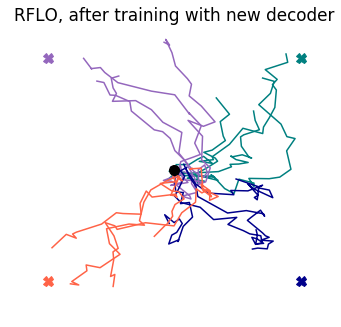

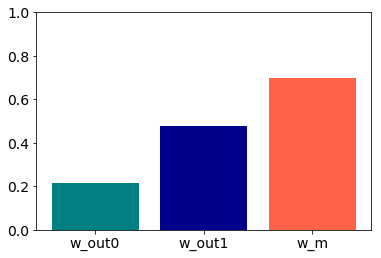

13it [00:00, 123.87it/s]

M norm: 0.89	 M angle: 0.71, 8 iterations
w_out1 norm: 1.47	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.89	 w_out1 vs. w_m angle: 0.71
w_m norm: 1.52	 w_out vs. w_m angle: 0.46

500it [00:03, 125.19it/s]
1500it [00:15, 96.43it/s]
500it [00:04, 124.19it/s]


AR early fit 0.902, late fit 0.930


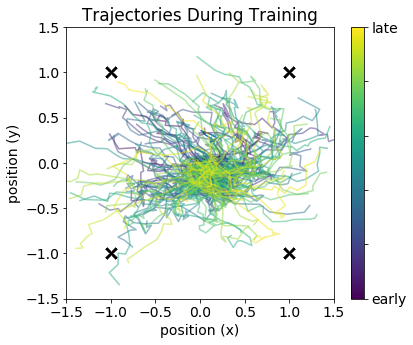

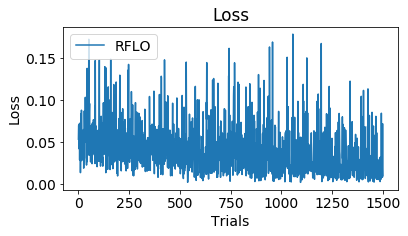

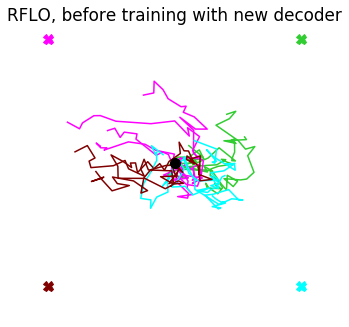

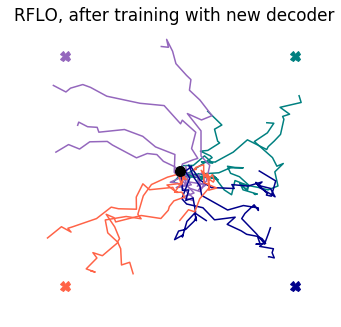

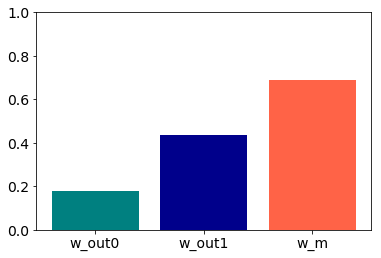

13it [00:00, 125.48it/s]

M norm: 0.72	 M angle: 0.80, 5 iterations
w_out1 norm: 1.47	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.72	 w_out1 vs. w_m angle: 0.80
w_m norm: 1.55	 w_out vs. w_m angle: 0.42

500it [00:04, 119.72it/s]
1500it [00:15, 94.69it/s]
500it [00:04, 117.57it/s]


AR early fit 0.902, late fit 0.925


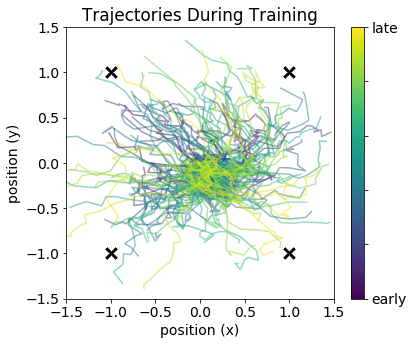

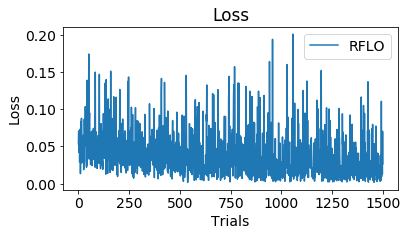

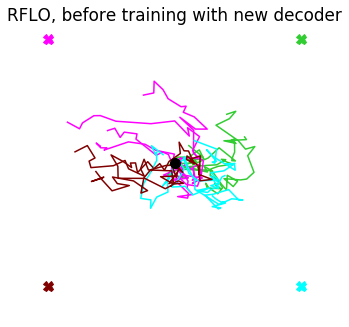

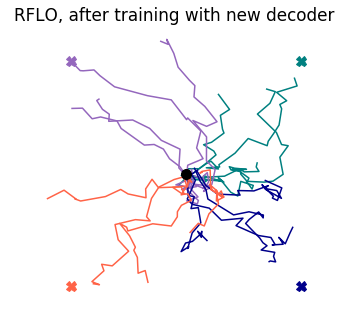

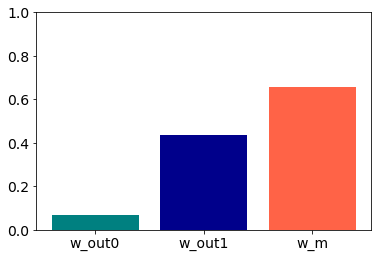

8it [00:00, 72.45it/s]

M norm: 0.53	 M angle: 0.90, 35 iterations
w_out1 norm: 1.47	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.53	 w_out1 vs. w_m angle: 0.90
w_m norm: 1.54	 w_out vs. w_m angle: 0.45

500it [00:04, 111.68it/s]
1500it [00:15, 95.70it/s]
500it [00:04, 120.81it/s]


AR early fit 0.902, late fit 0.922


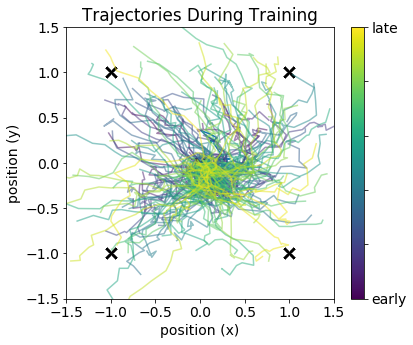

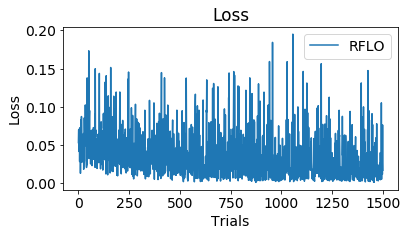

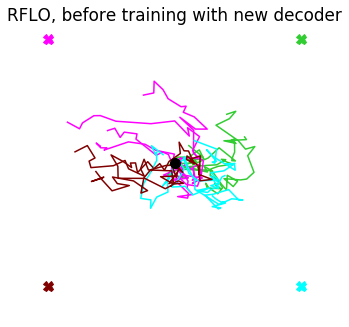

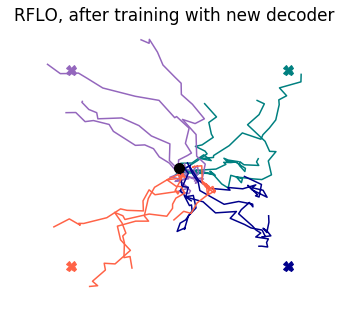

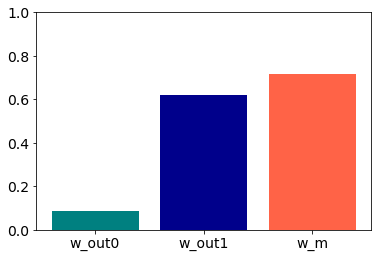

12it [00:00, 116.61it/s]

M norm: 0.00	 M angle: 1.00, 0 iterations
w_out1 norm: 1.47	 w_out vs. w_out1 angle: 0.51
w_m norm: 0.00	 w_out1 vs. w_m angle: 1.00
w_m norm: 1.47	 w_out vs. w_m angle: 0.51

500it [00:04, 126.01it/s]
1500it [00:16, 90.74it/s]
500it [00:03, 126.42it/s]


AR early fit 0.902, late fit 0.921


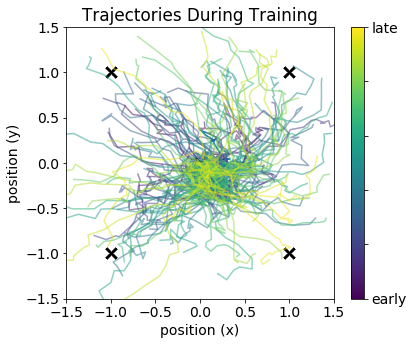

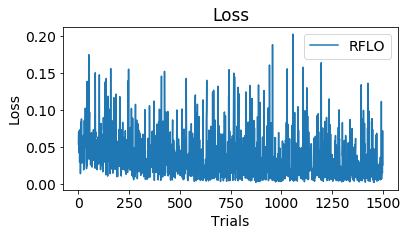

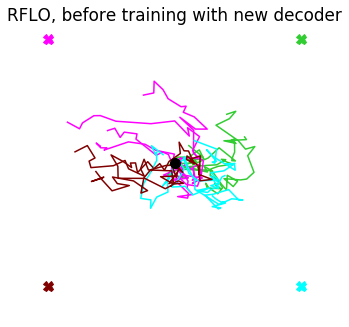

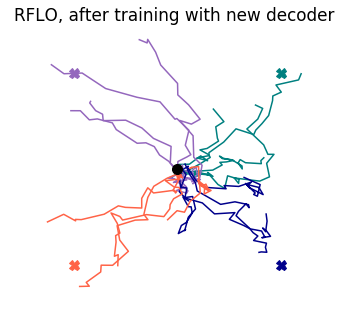

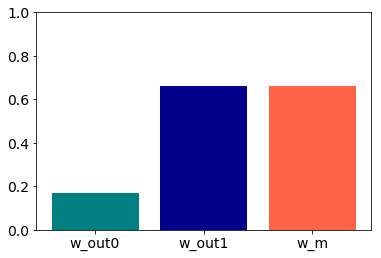

In [6]:
rnn_seed = 72
pretrain_duration = 2500
train_duration = 1500
test_duration = 500


# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,
               sig_in=0.0,sig_rec=0.5,sig_out=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(rnn_seed))
params.print_params()



# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=pretrain_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [0,22,33,47]
overlaps = [0.4,0.5,0.6,0.7,0.8,0.9,1]
n_changes = [60,50,50,50,30,30,0]
overlap_w_out0 = 0.5
n_change_w_out0 = 50


stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['seeds'] = seeds
stats['overlaps'] = overlaps
stats['n_changes'] = n_changes
stats['overlap_w_out0'] = overlap_w_out0
stats['n_change_w_out0'] = n_change_w_out0
stats['frac_on'] = frac_on
stats['RNNparams'] = params
stats['pretrain_duration'] = pretrain_duration
stats['train_duration'] = train_duration
stats['test_duration'] = test_duration
stats['rnn_seed'] = rnn_seed
stats['comments'] = 'vary overlap between M and w_out1'

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    

    for overlap,n_change in zip(overlaps,n_changes):
        
        """ let overlap between w_out0 and w_out1 be constant """
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        """ change overlap between w_out1 and w_m  """
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=train_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=test_duration, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    #stats['corrcoef'].append(corrcoef_list)



In [7]:
""" save dict with unique name """
stats_rflo_m = stats

""" save dict """

save = True
tag = 'sup-fig-stat-test-sig_rec-05-2022-8-01'


if save:
    
    with open(folder+'stats_rflo_m-'+tag+'.pickle', 'wb') as handle:
        pickle.dump(stats_rflo_m, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    print('\nsaved as '+folder+'stats_rflo_m-'+tag+'.pickle')



saved as figs-2022-8-1/stats_rflo_m-sup-fig-stat-test-sig_rec-05-2022-8-01.pickle


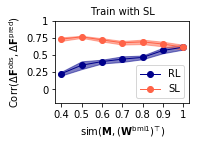

In [8]:
""" Same plot using flow field """
paper = True
save = True


fig,ax = plt.subplots(1,1,figsize=(6,4))

n_samples = len(stats_rflo_m['corr1'])
mn1 = np.mean(np.asarray(stats_rflo_m['corr1']),axis=0)
std1 = np.std(np.asarray(stats_rflo_m['corr1']),axis=0)
sem1 = std1/np.sqrt(n_samples)

mn2 = np.mean(np.asarray(stats_rflo_m['corr2']),axis=0)
std2 = np.std(np.asarray(stats_rflo_m['corr2']),axis=0)
sem2 = std2/np.sqrt(n_samples)

mn3 = np.mean(np.asarray(stats_rflo_m['corr3']),axis=0)
std3 = np.std(np.asarray(stats_rflo_m['corr3']),axis=0)
sem3 = std3/np.sqrt(n_samples)


# plt.plot(overlaps,mn1,'o-',linewidth=1,label=r'$W^{bmi0}$',color='teal')
# plt.fill_between(overlaps,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')


plt.plot(overlaps,mn2,'o-',linewidth=1,label='RL',color='darkblue')
plt.fill_between(overlaps,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')

plt.plot(overlaps,mn3,'o-',linewidth=1,label='SL',color='tomato')
plt.fill_between(overlaps,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')
plt.ylim([-0.2,1])
plt.legend()
plt.title('Train with SL')
plt.xlabel('sim('+r'$\mathbf{M},(\mathbf{W}^{\mathrm{bmi1}})^\top)$')
plt.ylabel('Corr'+r'$(\Delta \mathbf{F}^{\mathrm{obs}}, \Delta \mathbf{F}^{\mathrm{pred}})$')

plt.tight_layout()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.4,0.5,0.6,0.7,0.8,0.9,1],ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2.25,3))

plt.show()

if save:
    if paper:
        fig.savefig(folder+'sup-fig-stats-test-example-sig_rec-05.pdf')
    else:
        fig.savefig(folder+'sup-fig-stats-test-example-sig_rec-05.pdf')


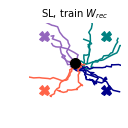

In [12]:
fig0 = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='SL, train '+r'$W_{rec}$')



save = True
paper = True

if paper:
    fig0,_ = paper_format(fig=fig0,ax=fig0.gca(),xlabels=None,ylabels=None,xlim=[-1.5,1.5],ylim=[-1.5,1.5],figsize=(2,2),labelsize=10)

if save:


    fig0.savefig(folder+'sup-fig-stats-test-example-trajectories-sig_rec-05.pdf')


# Plot comparison

In [13]:
""" Same plot using flow field """

def plot_ffcc(stats,overlaps,paper=False,save=False,sem=True,save_name='fig',fig=None):

    stats_rflo_m = stats

    if fig:
        ax = fig.gca()
    else:
        fig,ax = plt.subplots(1,1,figsize=(6,4))

    n_samples = len(stats_rflo_m['corr1'])
#     mn1 = np.mean(np.asarray(stats_rflo_m['corr1']),axis=0)
#     std1 = np.std(np.asarray(stats_rflo_m['corr1']),axis=0)
#     sem1 = std1
#     if sem:
#         sem1/=np.sqrt(n_samples)

    mn2 = np.mean(np.asarray(stats_rflo_m['corr2']),axis=0)
    std2 = np.std(np.asarray(stats_rflo_m['corr2']),axis=0)
    sem2 = std2
    if sem:
        sem2/=np.sqrt(n_samples)

    mn3 = np.mean(np.asarray(stats_rflo_m['corr3']),axis=0)
    std3 = np.std(np.asarray(stats_rflo_m['corr3']),axis=0)
    sem3 = std3
    if sem:
        sem3/=np.sqrt(n_samples)


    #plt.plot(overlaps,mn1,'o-',linewidth=1,label=r'$W^{bmi0}$',color='teal')
    #plt.fill_between(overlaps,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')


    plt.plot(overlaps,mn2,'o-',linewidth=1,label='RL',color='darkblue')
    plt.fill_between(overlaps,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')

    plt.plot(overlaps,mn3,'o-',linewidth=1,label='SL',color='tomato')
    plt.fill_between(overlaps,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')
    
    plt.ylim([-0.2,1])
    plt.legend()
    plt.title('Train with SL')
    plt.xlabel('sim('+r'$\mathbf{M},(\mathbf{W}^{\mathrm{bmi1}})^\top)$')
    plt.ylabel('Corr'+r'$(\Delta \mathbf{F}^{\mathrm{obs}}, \Delta \mathbf{F}^{\mathrm{pred}})$')

    plt.tight_layout()

    if paper:
        fig,ax = paper_format(fig=fig,ax=ax,xlabels=overlaps,ylabels=[0,0.25,0.5,0.75,1],ticksize=10,linewidth=2,ylim=[-.2,1],figsize=(2.25,3))

    if not fig:
        plt.show()

    if save:
        if paper:
            fig.savefig(folder+save_name+'.pdf')
        else:
            fig.savefig(folder+save_name+'.pdf')


In [15]:
pwd

'/Users/jacobportes/Documents/Code/rnn-learning/experiments/NeurIPS-rebuttal-2022-7-31'

p-value for 0.40: 0.000009
p-value for 0.50: 0.000283
p-value for 0.60: 0.000255
p-value for 0.70: 0.008643
p-value for 0.80: 0.000678
p-value for 0.90: 0.098534
p-value for 1.00: 1.000000


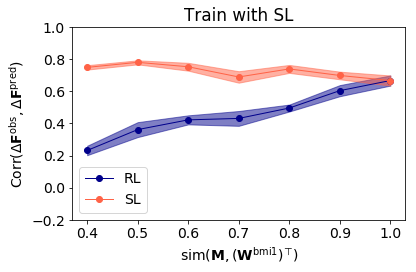

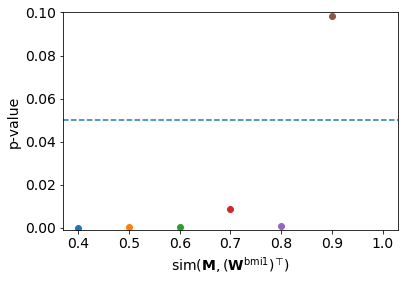

p-value for 0.40: 0.000025
p-value for 0.50: 0.000921
p-value for 0.60: 0.000293
p-value for 0.70: 0.005421
p-value for 0.80: 0.003473
p-value for 0.90: 0.177923
p-value for 1.00: 1.000000


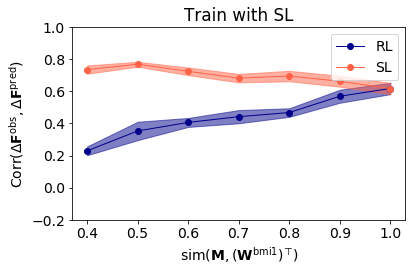

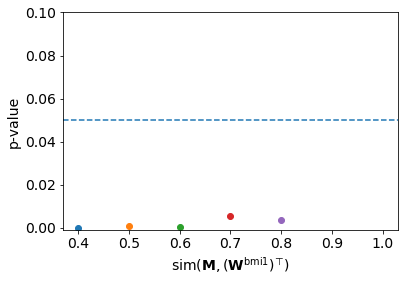

In [14]:
#fig,ax = plt.subplots(1,1,figsize=(6,4))
for key in ['01','05']:

    file = 'figs-2022-8-1/stats_rflo_m-sup-fig-stat-test-sig_rec-'+key+'-2022-8-01.pickle'
    with open(file, 'rb') as fp:
        stats_rflo_m = pickle.load(fp)
        
    overlaps = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    plot_ffcc(stats_rflo_m,overlaps=overlaps,paper=False,save=False,sem=True,save_name='fig')
    
    """ Plot p-value """
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    for i in range(len(overlaps)):
        # NOTE ORDER FOR SL CASE
        x = np.asarray(stats_rflo_m['corr2'])[:,i]
        y = np.asarray(stats_rflo_m['corr3'])[:,i]

        ttest = scipy.stats.ttest_ind(x,y)

        plt.plot(overlaps[i],ttest.pvalue,'o')
        print('p-value for {:.2f}: {:2f}'.format(overlaps[i],ttest.pvalue))

    plt.axhline(0.05,linestyle='--')
    plt.ylim(-0.001,0.1)
    plt.xlabel('sim('+r'$\mathbf{M},(\mathbf{W}^{\mathrm{bmi1}})^\top)$')
    plt.ylabel('p-value')
    plt.show()

In [49]:

overlaps = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for i in range(9):
    x = np.asarray(stats_reinforce_wout['corr1'])[:,i]
    y = np.asarray(stats_reinforce_wout['corr2'])[:,i]

    ttest = scipy.stats.ttest_ind(x,y)

    plt.plot(overlaps[i],ttest.pvalue,'o')
    
plt.axhline(0.05,linestyle='--')
plt.xlabel('sim('+r'$\mathbf{\hat{M}},\mathbf{W}^{\mathrm{bmi}1})$')
plt.ylabel('p-value')
plt.show()

'/Users/jacobportes/Documents/Code/rnn-learning/experiments/NeurIPS-rebuttal-2022-7-31'